<a href="https://colab.research.google.com/github/zacksnyder-lsds/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
# TODO - code!
#Imports!!!!!!! =) 
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# defining a function to calculate bayesian probability 
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):
  p_notdrunk_prior = 1 - prob_drunk_prior
  numeratior = true_positive_rate * prob_drunk_prior
  denominator = (true_positive_rate * prob_drunk_prior) + (false_positive_rate * p_notdrunk_prior)
  total = numeratior / denominator
  return total 

In [5]:
# finding baysian probablity if one test is run 
one_test = prob_drunk_given_positive(.001, .08, 1)
one_test

0.012357884330202669

In [6]:
#running the second test with the updated probability from above 
two_test = prob_drunk_given_positive(one_test, .08, 1)
two_test

0.13525210993291495

In [7]:
#seeing how many tests needed to reach 95% confidence 
three_test = prob_drunk_given_positive(two_test, .08, 1)
print(three_test) 

four_test = prob_drunk_given_positive(three_test, .08, 1)
print(four_test) 

five_test = prob_drunk_given_positive(four_test, .08, 1)
print(five_test) 

six_test = prob_drunk_given_positive(five_test, .08, 1)
print(six_test) 

0.6615996951348605
0.9606895076105054
0.9967371577896734
0.9997381867081508


#It took four tests to be above 95% confident that the individual was drunk driving from a baysian perspective 

In [0]:
#looking into bayesian confidence interval documentation
?stats.bayes_mvs

In [11]:
#reading in the data to compare the confidence intervals between baysian and frequentist 
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
fire_data = pd.read_csv(url)
fire_data.sample(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
445,5,5,aug,sun,94.0,47.9,100.7,10.7,17.3,80,4.5,0.0,0.00
375,6,5,sep,sat,91.2,94.3,744.4,8.4,15.4,57,4.9,0.0,39.35
484,2,5,aug,sun,94.9,130.3,587.1,14.1,33.1,25,4.0,0.0,26.43
166,6,5,aug,wed,92.1,111.2,654.1,9.6,16.6,47,0.9,0.0,2.29
352,7,4,sep,fri,92.1,99.0,745.3,9.6,20.6,43,3.6,0.0,2.03


In [21]:
#calculating baysian confidence interval 
bayes_confidence = stats.bayes_mvs(fire_data['temp'], alpha=.95)[0][1] #indexing 0 because I only want mean confidence interval for comparison
#indexing 1 so I can get just the minmax for plotting 
bayes_confidence  

(18.38746551815681, 19.39087103890315)

In [16]:
# making a variable for mean for plotting purposes 
mean = fire_data['temp'].mean()
mean

18.88916827852998

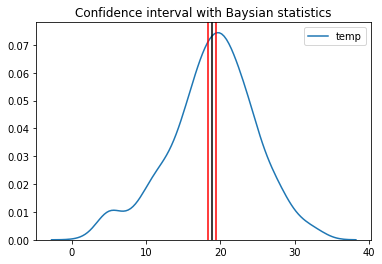

In [24]:
sns.kdeplot(fire_data['temp'])
plt.axvline(x=bayes_confidence[0], color='red')
plt.axvline(x=bayes_confidence[1], color='red')
plt.axvline(x=mean, color='black')
plt.title('Confidence interval with Baysian statistics');

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!